In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We've talked about Random Forests. Now it's time to build one.

Here we'll use data from Lending Club to predict the state of a loan given some information about it. You can find the dataset [here](https://www.lendingclub.com/info/download-data.action). We'll use 2015 data. ([Thinkful mirror](https://www.dropbox.com/s/m7z42lubaiory33/LoanStats3d.csv?dl=0))

In [3]:
# Replace the path with the correct path for your data.
y2015 = pd.read_csv("LoanStats3d.csv",
    skipinitialspace=True,
    header=1
)

# Note the warning about dtypes.

c:\users\kylem\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (0,19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
y2015.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,20000.0,20000.0,20000.0,36 months,6.49%,612.89,A,A2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,10000.0,10000.0,10000.0,36 months,12.88%,336.37,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,18000.0,18000.0,18000.0,36 months,7.49%,559.83,A,A4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,20000.0,20000.0,20000.0,36 months,5.32%,602.30,A,A1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,16000.0,16000.0,16000.0,60 months,12.88%,363.07,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


## The Blind Approach

Now, as we've seen before, creating a model is the easy part. Let's try just using everything we've got and throwing it without much thought into a Random Forest. SKLearn requires the independent variables to be be numeric, and all we want is dummy variables so let's use `get_dummies` from Pandas to generate a dummy variable for every categorical colummn and see what happens off of this kind of naive approach.

In [ ]:
# from sklearn import ensemble
# from sklearn.model_selection import cross_val_score

# rfc = ensemble.RandomForestClassifier()
# X = y2015.drop('loan_status', 1)
# Y = y2015['loan_status']
# X = pd.get_dummies(X)

# cross_val_score(rfc, X, Y, cv=5)

Did your kernel die? My kernel died.

Guess it isn't always going to be that easy...

Can you think of what went wrong?

(You're going to have to reset your kernel and reload the column, BUT DON'T RUN THE MODEL AGAIN OR YOU'LL CRASH THE KERNEL AGAIN!)

## Data Cleaning

Well, `get_dummies` can be a very memory intensive thing, particularly if data are typed poorly. We got a warning about that earlier. Mixed data types get converted to objects, and that could create huge problems. Our dataset is about 400,000 rows. If there's a bad type there its going to see 400,000 distinct values and try to create dummies for all of them. That's bad. Lets look at all our categorical variables and see how many distinct counts there are...

In [4]:
categorical = y2015.select_dtypes(include=['object'])
for i in categorical:
    column = categorical[i]
    print(i)
    print(column.nunique())

id
2
term
2
int_rate
111
grade
7
sub_grade
35
emp_title
120812
emp_length
11
home_ownership
4
verification_status
3
issue_d
12
loan_status
7
pymnt_plan
2
desc
34
purpose
14
title
27
zip_code
914
addr_state
49
earliest_cr_line
668
revol_util
1211
initial_list_status
2
last_pymnt_d
46
next_pymnt_d
5
last_credit_pull_d
47
application_type
2
verification_status_joint
1
hardship_flag
2
hardship_type
1
hardship_reason
9
hardship_status
3
hardship_start_date
21
hardship_end_date
22
payment_plan_start_date
22
hardship_loan_status
4
disbursement_method
1
debt_settlement_flag
2
debt_settlement_flag_date
39
settlement_status
3
settlement_date
42


Well that right there is what's called a problem. Some of these have over a hundred thousand distinct types. Lets drop the ones with over 30 unique values, converting to numeric where it makes sense. In doing this there's a lot of code that gets written to just see if the numeric conversion makes sense. It's a manual process that we'll abstract away and just include the conversion.

You could extract numeric features from the dates, but here we'll just drop them. There's a lot of data, it shouldn't be a huge problem.

In [5]:
# Convert ID and Interest Rate to numeric.
y2015['id'] = pd.to_numeric(y2015['id'], errors='coerce')
y2015['int_rate'] = pd.to_numeric(y2015['int_rate'].str.strip('%'), errors='coerce')

# Drop other columns with many unique variables
y2015.drop(['url', 'emp_title', 'zip_code', 'earliest_cr_line', 'revol_util',
            'sub_grade', 'addr_state', 'desc'], 1, inplace=True)

Wonder what was causing the dtype error on the id column, which _should_ have all been integers? Let's look at the end of the file.

In [6]:
y2015.tail()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
421092,NaN,NaN,13000.0,13000.0,13000.0,60 months,15.99,316.07,D,5 years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421093,NaN,NaN,12000.0,12000.0,12000.0,60 months,19.99,317.86,E,1 year,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421094,NaN,NaN,20000.0,20000.0,20000.0,36 months,11.99,664.20,B,10+ years,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
421096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Remove two summary rows at the end that don't actually contain data.
y2015 = y2015[:-2]

Now this should be better. Let's try again.

In [8]:
pd.get_dummies(y2015).head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,settlement_date_Nov-2016,settlement_date_Nov-2017,settlement_date_Oct-2015,settlement_date_Oct-2016,settlement_date_Oct-2017,settlement_date_Oct-2018,settlement_date_Sep-2015,settlement_date_Sep-2016,settlement_date_Sep-2017,settlement_date_Sep-2018
0,NaN,NaN,20000.0,20000.0,20000.0,6.49,612.89,55000.0,29.15,0.0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,10000.0,10000.0,10000.0,12.88,336.37,91392.0,9.44,0.0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,18000.0,18000.0,18000.0,7.49,559.83,75000.0,25.65,0.0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,20000.0,20000.0,20000.0,5.32,602.30,65000.0,18.83,0.0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,NaN,16000.0,16000.0,16000.0,12.88,363.07,90000.0,6.39,0.0,...,0,0,0,0,0,0,0,0,0,0


It finally works! We had to sacrifice sub grade, state address and description, but that's fine. If you want to include them you could run the dummies independently and then append them back to the dataframe.

## Second Attempt

Now let's try this model again.

We're also going to drop NA columns, rather than impute, because our data is rich enough that we can probably get away with it.

This model may take a few minutes to run.

In [9]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = y2015.drop('loan_status', 1)
Y = y2015['loan_status']
X = pd.get_dummies(X)
X = X.dropna(axis=1)

cross_val_score(rfc, X, Y, cv=10)

array([0.98831715, 0.98786569, 0.98556231, 0.98786512, 0.9876036 ,
       0.98570377, 0.98679617, 0.98907571, 0.9879355 , 0.98914644])

### DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [119]:
# start with chi2 test
# do feature importance on whole dataset with random_forests
# start with variance threshold then do feature_importance
# t-tests and chi2-tests
# then after 10 features identified, use RFE

In [11]:
X.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,settlement_date_Nov-2016,settlement_date_Nov-2017,settlement_date_Oct-2015,settlement_date_Oct-2016,settlement_date_Oct-2017,settlement_date_Oct-2018,settlement_date_Sep-2015,settlement_date_Sep-2016,settlement_date_Sep-2017,settlement_date_Sep-2018
0,20000.0,20000.0,20000.0,6.49,612.89,55000.0,0.0,0.0,9.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,10000.0,10000.0,10000.0,12.88,336.37,91392.0,0.0,0.0,13.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,18000.0,18000.0,18000.0,7.49,559.83,75000.0,0.0,1.0,12.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,20000.0,20000.0,20000.0,5.32,602.30,65000.0,0.0,1.0,12.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,16000.0,16000.0,16000.0,12.88,363.07,90000.0,0.0,0.0,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#t-test or chi2 test

In [ ]:
y2015['loan']

#### Variance Threshold

In [10]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.5)
selector.fit(X)

VarianceThreshold(threshold=0.5)

In [11]:
df_features = X.loc[:,selector.get_support(indices=False)]
rev_features = list(df_features.columns)

In [12]:
X_rev = X[rev_features]

#### Correlation matrices

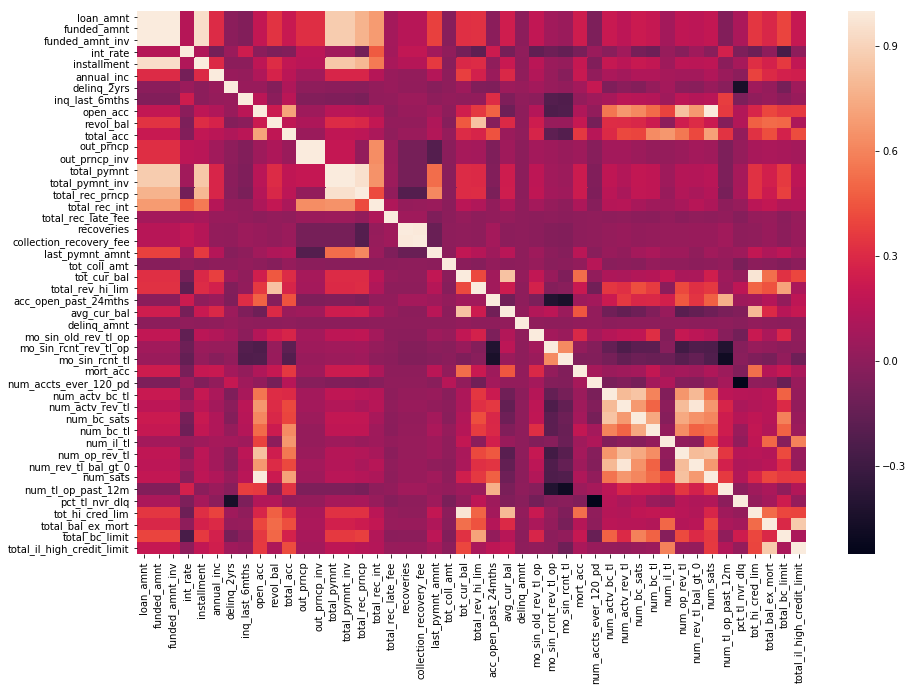

In [73]:
import seaborn as sns
corr = X_rev.corr()
plt.figure(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)
plt.show()

#### Feature importances

In [13]:
y2015['loan_status'].value_counts()

Fully Paid            269699
Current                74267
Charged Off            71761
Late (31-120 days)      2933
In Grace Period         1514
Late (16-30 days)        773
Default                  148
Name: loan_status, dtype: int64

In [14]:
from sklearn.ensemble import ExtraTreesClassifier
forest = ExtraTreesClassifier()
forest.fit(X_rev, Y)

importances = forest.feature_importances_ 

In [15]:
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_rev.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 12 (0.191762)
2. feature 11 (0.162766)
3. feature 15 (0.115308)
4. feature 13 (0.074322)
5. feature 20 (0.073339)
6. feature 2 (0.056043)
7. feature 14 (0.047935)
8. feature 19 (0.044324)
9. feature 16 (0.043563)
10. feature 1 (0.038980)
11. feature 18 (0.035936)
12. feature 4 (0.031477)
13. feature 0 (0.024904)
14. feature 3 (0.012510)
15. feature 17 (0.004544)
16. feature 24 (0.001868)
17. feature 40 (0.001769)
18. feature 38 (0.001643)
19. feature 27 (0.001636)
20. feature 22 (0.001571)
21. feature 5 (0.001493)
22. feature 44 (0.001484)
23. feature 35 (0.001479)
24. feature 25 (0.001464)
25. feature 32 (0.001456)
26. feature 10 (0.001444)
27. feature 29 (0.001435)
28. feature 36 (0.001418)
29. feature 23 (0.001418)
30. feature 33 (0.001406)
31. feature 9 (0.001402)
32. feature 28 (0.001398)
33. feature 37 (0.001398)
34. feature 42 (0.001387)
35. feature 34 (0.001380)
36. feature 43 (0.001378)
37. feature 45 (0.001362)
38. feature 39 (0.001313)
39. feature

In [16]:
order_importances = np.argsort(importances)[::-1]
for feat, importance in zip(X_rev.columns, importances):
    print ('feature: {%s}, importance: {%s}' % (feat, importance))

feature: {loan_amnt}, importance: {0.024904269964445783}
feature: {funded_amnt}, importance: {0.03897996163939732}
feature: {funded_amnt_inv}, importance: {0.05604252007211082}
feature: {int_rate}, importance: {0.012509785101163459}
feature: {installment}, importance: {0.031476939399890394}
feature: {annual_inc}, importance: {0.0014933405265346222}
feature: {delinq_2yrs}, importance: {0.0009821760158688455}
feature: {inq_last_6mths}, importance: {0.0012847209644738196}
feature: {open_acc}, importance: {0.0012882212138568703}
feature: {revol_bal}, importance: {0.0014022682635946137}
feature: {total_acc}, importance: {0.0014441523379003477}
feature: {out_prncp}, importance: {0.1627663206300876}
feature: {out_prncp_inv}, importance: {0.1917623016251064}
feature: {total_pymnt}, importance: {0.07432224754495231}
feature: {total_pymnt_inv}, importance: {0.04793539565108214}
feature: {total_rec_prncp}, importance: {0.11530756239857953}
feature: {total_rec_int}, importance: {0.0435627454672002

In [17]:
X_rev2 = X_rev[['out_prncp','out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 
                'last_pymnt_amnt', 'funded_amnt_inv', 'loan_amnt', 'collection_recovery_fee', 
                'recoveries', 'funded_amnt' ]]

In [18]:
X_rev_final = X_rev[['out_prncp', 'out_prncp_inv', 'total_rec_prncp']]

In [19]:
# Your code here.
rfc = ensemble.RandomForestClassifier()

cross_val_score(rfc, X_rev_final, Y, cv=10)

array([0.96974806, 0.98202413, 0.98207162, 0.98273569, 0.98247406,
       0.9797668 , 0.97534969, 0.97789019, 0.97867338, 0.98050159])

#### Recursive Feature Elimination

In [20]:
from sklearn.feature_selection import RFECV

rfe = RFECV(rfc, cv=2)
rfe = rfe.fit(X_rev2, Y)

print(rfe.ranking_)
# print(rfe.score_)

[1 1 4 6 1 1 3 1 2 1 5]


In [21]:
X_rev_RFE = X_rev[['out_prncp','out_prncp_inv', 'total_rec_prncp', 'last_pymnt_amnt', 'loan_amnt', 'recoveries']]

In [24]:
cross_val_score(rfc, X_rev_RFE, Y, cv=10)

array([0.97423598, 0.98729578, 0.98572853, 0.98596533, 0.98503883,
       0.98354271, 0.97494597, 0.98045502, 0.98142827, 0.98674773])

After using VarianceThreshold, the number of features declined from 471 to 46. 46 was the lowest number of features I could get once reducing the threshold to 0.5. Then, I was able to further reduce the feature set with calculating the feature importances method. Looking at the correlation matrix doesn't seem like the most scientific method of removing features, it was better to have figures to rank the features. I played around with my top features to remove as many as possible until I was within the 90% accuracy metric. I was able to get the classifier to only need 3 features with an average accuracy around 98%. Using just 2 features dropped the accuracy down to around 80%.

In addition to the trial method above after running features_importances_, I also tried using recursive feature elimination to get the minimal amount of features necessary for the model. According to RFE, 6 of my final features would produce the most accurate model. 

In [ ]:
# separate version using PCA only for further analysis